In [269]:
import numpy as np
import pandas as pd
import math
from statistics import mean
import os

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator, FixedLocator,FormatStrFormatter

graph = 'x'

date = '7_19_2021'

refants = ['DA59','DV11','DA49','DV12','PM01','DV07']

dates = ['7-01 T09:30','7-02 T06:49','7-04 T19:18','7-05 T12:04','7-06 T00:49','7-06 T16:19','7-07 T00:18',
         '7-07 T15:56','7-07 T19:11','7-08 T00:16','7-08 T06:41','7-08 T11:29','7-08 T15:51','7-08 T20:50',
         '7-09 T01:32','7-09 T11:51','7-10 T23:17','7-11 T01:03','7-11 T10:46','7-11 T22:13','7-12 T00:59',
         '7-12 T20:32','7-13 T00:18','7-15 T00:24','7-15 T10:57','7-16 T00:54','7-16 T12:39','7-17 T14:23',
         '7-17 T19:27','7-18 T01:07','7-18 T20:11','7-19 T10:46','7-19 T14:47','7-19 T18:21','7-19 T22:41']

antLocs = pd.DataFrame([[2224943.808754,-5440201.5262,-2481486.752257],[2225075.807979,-5440179.672387,-2481412.224847],[2224995.224195,-5440073.176024,-2481713.361151],
                      [2224233.562158,-5439963.33682,-2482603.337877],[2226160.421818,-5439676.322733,-2481419.064179],[2225130.368168,-5440025.149959,-2481695.420672]],
                      columns=['geoX','geoY','geoZ'],index=['DA59','DV11','DA49','DV12','PM01','DV07'])
weaLocs = pd.DataFrame([[2226292.373,-5440071.187,-2480490.57],[2223475.222,-5440620.327,-2481822.703],[2226146.018,-5439167.973,-2482751.669],
                      [2218047.888,-5442740.475,-2480988.859],[2229937.944,-5435387.75,-2486806.917],[2229279.046,-5440478.349,-2476637.931],
                      [2225008.773,-5440202.705,-2481447.213],[2202176.215,-5445210.627,-2485352.924]],
                      columns=['geoX','geoY','geoZ'],index=['Meteo129','Meteo130','Meteo131','Meteo201','Meteo309','Meteo410','MeteoCentral','MeteoItinerant'])

In [270]:
if graph == 'x':
    index = 0
elif graph == 'y':
    index = 1
else:
    index = 2

def distance(pt1,pt2): #antLocs then weaLocs
    return math.sqrt((antLocs.loc[pt1,antLocs.columns[0]]-weaLocs.loc[pt2,weaLocs.columns[0]])**2+(antLocs.loc[pt1,antLocs.columns[1]]-weaLocs.loc[pt2,weaLocs.columns[1]])**2+(antLocs.loc[pt1,antLocs.columns[2]]-weaLocs.loc[pt2,weaLocs.columns[2]])**2)

def nearestWeatherStation(ants):
    ant1 = ants[0]
    ant2 = ants[1]
    bestStat1 = weaLocs.index[0]
    bestStat2 = weaLocs.index[0]
    bestDist1 = distance(ant1,bestStat1)
    bestDist2 = distance(ant2,bestStat1)

    for i in range(weaLocs.shape[0]):
        if distance(ant1,weaLocs.index[i]) < bestDist1:
            bestStat1 = weaLocs.index[i]
            bestDist1 = distance(ant1,weaLocs.index[i])
        if distance(ant2,weaLocs.index[i]) < bestDist2:
            bestStat2 = weaLocs.index[i]
            bestDist2 = distance(ant2,weaLocs.index[i])

    if bestStat1 != bestStat2:
        if mean([distance(ant1,bestStat1),distance(ant2,bestStat1)]) > mean([distance(ant1,bestStat2),distance(ant2,bestStat2)]):
            station = bestStat2
        else:
            station = bestStat1
    else:
        station = bestStat1

    return station

# magnitude w/ mean-based normalization

In [271]:
if not os.path.isdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/offsetplots/'):
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/offsetplots/')
directory = '/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/'

numOfObs = 0
for file in os.listdir(directory):
    if os.path.isdir(directory+file) and file[:3] == 'uid':
        numOfObs += 1
        
names = pd.Series(refants)
probs = np.empty((names.shape[0],numOfObs,5),dtype='U25')
times = np.empty((names.shape[0],numOfObs,1),dtype='float')
errors = np.empty((names.shape[0],numOfObs,3),dtype='float')
mag = np.empty((names.shape[0],numOfObs,3),dtype='float')

for ant in range(len(refants)):
    arr = pd.read_csv(directory+refants[ant]+'.csv').to_numpy(dtype='U25')
    for row in range(np.shape(arr)[0]):
        if "nan" in arr[row,:]:
            arr[row,5:11] = arr[row-1,5:11]
            L = np.where(probs[ant,:,0] == "")[0][0]
            probs[ant,L,0] = refants[ant]
            probs[ant,L,4] = row+1
            probs[ant,L,1:4] = arr[row,5:8]

    times[ant,:,0] = arr[:,0]
    errors[ant,:,:] = arr[:,8:11]
    mag[ant,:,:] = arr[:,5:8]

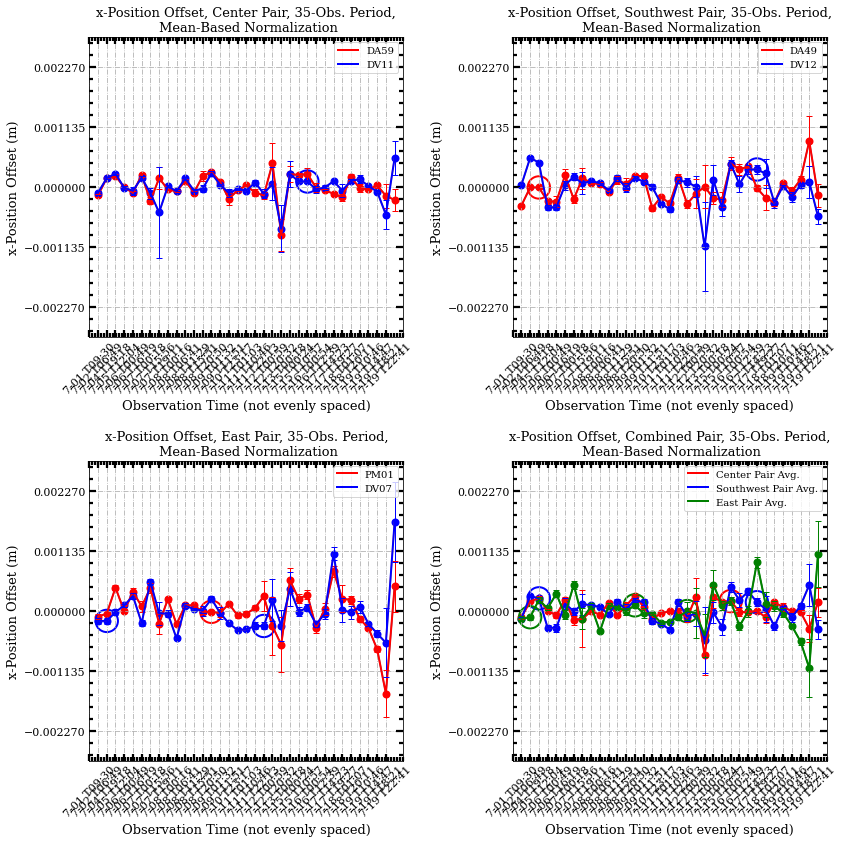

In [272]:
for i in range(names.shape[0]): 
    offset = np.average(mag[i,:,index])
    mag[i,:,index] = mag[i,:,index]-offset
    if probs[i,0,0] != "":
        for j in range(np.where(probs[i,:,0] == "")[0][0]):
            probs[i,j,index+1] = float(probs[i,j,index+1])-offset

maxima = np.empty((names.shape[0],1,2),dtype='float')
for i in range(names.shape[0]):
    maxima[i,0,0], maxima[i,0,1] = np.max((mag[i,:,index]+errors[i,:,index])), np.min((mag[i,:,index]-errors[i,:,index]))

magAvg = np.empty((int(names.shape[0]/2),numOfObs,3),dtype='float')
errorAvg = np.empty((int(names.shape[0]/2),numOfObs,3),dtype='float')
for i in range(3): 
    magAvg[i,:,:] = (mag[i*2,:,:]+mag[i*2+1,:,:])/2
    errorAvg[i,:,:] = (errors[i*2,:,:]+errors[i*2+1,:,:])/2
    
probsAvg = np.empty((int(names.shape[0]/2),numOfObs,4),dtype='U25')
temp = np.empty((1,4),dtype='U25')
for j in range(names.shape[0]):
    i = j // 2
    if probs[j,0,0] != "":
        for row in range(np.shape(probs[j,:np.where(probs[j,:,0] == "")[0][0],:])[0]):
            L = np.where(probsAvg[i,:,0] == "")[0][0]
            probsAvg[i,L,3] = probs[j,row,4]
            probsAvg[i,L,:3] = magAvg[i,int(probsAvg[i,L,3])-1,:]
            
for i in range(int(names.shape[0]/2)): magAvg[i,:,index] = magAvg[i,:,index]-np.average(magAvg[i,:,index])
        
xmin, xmax = 0, np.shape(times[0,:,:])[0]+1
ymax, ymin = np.max((maxima[:,0,0]))+0.0004, np.min((maxima[:,0,1]))-0.0004

if abs(ymax) > abs(ymin):
    ymin = -ymax
else:
    ymax = abs(ymin)

x = range(1,numOfObs+1)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))

########## Center Array
title=graph+'-Position Offset, Center Pair, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization'
xlabel='Observation Time (not evenly spaced)'
ylabel=graph+'-Position Offset (m)'

xMajors,xMinors = np.shape(times[0,:,:])[0],3
yMajors,yMinors = 5,5

ax1.plot(x,mag[0,:,index],color='r',linestyle='-',linewidth=2,label=names.iloc[0])
ax1.scatter(x,mag[0,:,index],color='r',linestyle='-',linewidth=2)
ax1.errorbar(x, mag[0,:,index], yerr=errors[0,:,index], ecolor='r', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[0,0,0] != "":
    for row in range(np.where(probs[0,:,0] == "")[0][0]):
        ax1.scatter(float(probs[0,row,4]),float(probs[0,row,index+1]),s=500,c='none',edgecolors='r',linestyle='-',linewidth=2)

ax1.plot(x,mag[1,:,index],color='b',linestyle='-',linewidth=2,label=names.iloc[1])
ax1.scatter(x,mag[1,:,index],color='b',linestyle='-',linewidth=2)
ax1.errorbar(x, mag[1,:,index], yerr=errors[1,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[1,0,0] != "":
    for row in range(np.where(probs[1,:,0] == "")[0][0]):
        ax1.scatter(float(probs[1,row,4]),float(probs[1,row,index+1]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=2)

plt.rc("font", size=16,family='serif')

ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
x_major_ticks = MultipleLocator((xmax - xmin) / xMajors)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax1.xaxis.set_major_locator(x_major_ticks)
ax1.yaxis.set_major_locator(y_major_ticks)
ax1.xaxis.set_minor_locator(x_minor_ticks)
ax1.yaxis.set_minor_locator(y_minor_ticks)
ax1.grid(True, linestyle='-.')
ax1.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax1.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax1.set_xticks(range(numOfObs))
ax1.set_xticklabels(dates)
ax1.set_xlabel(xlabel,fontsize=13)
ax1.set_ylabel(ylabel,fontsize=13)
ax1.set_title(title,fontsize=13)
ax1.tick_params('x', labelrotation=45)
plt.tight_layout()

ax1.legend(loc=1,fontsize=10)

########## Southwest Array
title=graph+'-Position Offset, Southwest Pair, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization'
xlabel='Observation Time (not evenly spaced)'
ylabel=graph+'-Position Offset (m)'

xMajors,xMinors = np.shape(times[0,:,:])[0],3
yMajors,yMinors = 5,5

ax2.plot(x,mag[2,:,index],color='r',linestyle='-',linewidth=2,label=names[2])
ax2.scatter(x,mag[2,:,index],color='r',linestyle='-',linewidth=2)
ax2.errorbar(x, mag[2,:,index], yerr=errors[2,:,index], ecolor='r', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[2,0,0] != "":
    for row in range(np.where(probs[2,:,0] == "")[0][0]):
        ax2.scatter(float(probs[2,row,4]),float(probs[2,row,index+1]),s=500,c='none',edgecolors='r',linestyle='-',linewidth=2)
        
ax2.plot(x,mag[3,:,index],color='b',linestyle='-',linewidth=2,label=names[3])
ax2.scatter(x,mag[3,:,index],color='b',linestyle='-',linewidth=2)
ax2.errorbar(x, mag[3,:,index], yerr=errors[3,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[3,0,0] != "":
    for row in range(np.where(probs[3,:,0] == "")[0][0]):
        ax2.scatter(float(probs[3,row,4]),float(probs[3,row,index+1]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=2)

plt.rc("font", size=16,family='serif')

ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
x_major_ticks = MultipleLocator((xmax - xmin) / xMajors)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax2.xaxis.set_major_locator(x_major_ticks)
ax2.yaxis.set_major_locator(y_major_ticks)
ax2.xaxis.set_minor_locator(x_minor_ticks)
ax2.yaxis.set_minor_locator(y_minor_ticks)
ax2.grid(True, linestyle='-.')
ax2.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax2.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax2.set_xticks(range(numOfObs))
ax2.set_xticklabels(dates)
ax2.set_xlabel(xlabel,fontsize=13)
ax2.set_ylabel(ylabel,fontsize=13)
ax2.set_title(title,fontsize=13)
ax2.tick_params('x', labelrotation=45)
plt.tight_layout()

ax2.legend(loc=1,fontsize=10)

########## East Array
title=graph+'-Position Offset, East Pair, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization'
xlabel='Observation Time (not evenly spaced)'
ylabel=graph+'-Position Offset (m)'

xMajors,xMinors = np.shape(times[0,:,:])[0],3
yMajors,yMinors = 5,5

ax3.plot(x,mag[4,:,index],color='r',linestyle='-',linewidth=2,label=names[4])
ax3.scatter(x,mag[4,:,index],color='r',linestyle='-',linewidth=2)
ax3.errorbar(x, mag[4,:,index], yerr=errors[4,:,index], ecolor='r', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[4,0,0] != "":
    for row in range(np.where(probs[4,:,0] == "")[0][0]):
        ax3.scatter(float(probs[4,row,4]),float(probs[4,row,index+1]),s=500,c='none',edgecolors='r',linestyle='-',linewidth=2)
        
ax3.plot(x,mag[5,:,index],color='b',linestyle='-',linewidth=2,label=names[5])
ax3.scatter(x,mag[5,:,index],color='b',linestyle='-',linewidth=2)
ax3.errorbar(x, mag[5,:,index], yerr=errors[5,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[5,0,0] != "":
    for row in range(np.where(probs[5,:,0] == "")[0][0]):
        ax3.scatter(float(probs[5,row,4]),float(probs[5,row,index+1]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=2)

plt.rc("font", size=16,family='serif')

ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
x_major_ticks = MultipleLocator((xmax - xmin) / xMajors)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax3.xaxis.set_major_locator(x_major_ticks)
ax3.yaxis.set_major_locator(y_major_ticks)
ax3.xaxis.set_minor_locator(x_minor_ticks)
ax3.yaxis.set_minor_locator(y_minor_ticks)
ax3.grid(True, linestyle='-.')
ax3.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax3.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax3.set_xticks(range(numOfObs))
ax3.set_xticklabels(dates)
ax3.set_xlabel(xlabel,fontsize=13)
ax3.set_ylabel(ylabel,fontsize=13)
ax3.set_title(title,fontsize=13)
ax3.tick_params('x', labelrotation=45)
plt.tight_layout()

ax3.legend(loc=1,fontsize=10)

########## Combined Array
title=graph+'-Position Offset, Combined Pair, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization'
xlabel='Observation Time (not evenly spaced)'
ylabel=graph+'-Position Offset (m)'

xMajors,xMinors = np.shape(times[0,:,:])[0],3
yMajors,yMinors = 5,5

ax4.plot(x,magAvg[0,:,index],color='r',linestyle='-',linewidth=2,label="Center Pair Avg.")
ax4.scatter(x,magAvg[0,:,index],color='r',linestyle='-',linewidth=2)
ax4.errorbar(x,magAvg[0,:,index], yerr=errorAvg[0,:,index], ecolor='r', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probsAvg[0,0,0] != "":
    for row in range(np.where(probsAvg[0,:,:] == "")[0][0]):
        ax4.scatter(float(probsAvg[0,row,3]),float(probsAvg[0,row,index]),s=500,c='none',edgecolors='r',linestyle='-',linewidth=2)

ax4.plot(x,magAvg[1,:,index],color='b',linestyle='-',linewidth=2,label="Southwest Pair Avg.")
ax4.scatter(x,magAvg[1,:,index],color='b',linestyle='-',linewidth=2)
ax4.errorbar(x,magAvg[1,:,index], yerr=errorAvg[1,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probsAvg[1,0,0] != "":
    for row in range(np.where(probsAvg[1,:,:] == "")[0][0]):
        ax4.scatter(float(probsAvg[1,row,3]),float(probsAvg[1,row,index]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=2)

ax4.plot(x,magAvg[2,:,index],color='g',linestyle='-',linewidth=2,label="East Pair Avg.")
ax4.scatter(x,magAvg[2,:,index],color='g',linestyle='-',linewidth=2)
ax4.errorbar(x,magAvg[2,:,index], yerr=errorAvg[2,:,index], ecolor='g', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probsAvg[2,0,0] != "":
    for row in range(np.where(probsAvg[2,:,:] == "")[0][0]):
        ax4.scatter(float(probsAvg[2,row,3]),float(probsAvg[2,row,index]),s=500,c='none',edgecolors='g',linestyle='-',linewidth=2)

plt.rc("font", size=16,family='serif')

ax4.set_xlim(xmin,xmax)
ax4.set_ylim(ymin,ymax)
x_major_ticks = MultipleLocator((xmax - xmin) / xMajors)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax4.xaxis.set_major_locator(x_major_ticks)
ax4.yaxis.set_major_locator(y_major_ticks)
ax4.xaxis.set_minor_locator(x_minor_ticks)
ax4.yaxis.set_minor_locator(y_minor_ticks)
ax4.grid(True, linestyle='-.')
ax4.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax4.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax4.set_xticks(range(numOfObs))
ax4.set_xticklabels(dates)
ax4.set_xlabel(xlabel,fontsize=13)
ax4.set_ylabel(ylabel,fontsize=13)
ax4.set_title(title,fontsize=13)
ax4.tick_params('x', labelrotation=45)
plt.tight_layout()

ax4.legend(loc=1,fontsize=10)

plt.show()
#plt.savefig(directory+'offsetplots/offsetmag'+graph.capitalize()+'.png', bbox_inches='tight')
#plt.close()


#'''

# delta w/ mean-based normalization

In [273]:
if not os.path.isdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/offsetplots/'):
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/offsetplots/')
directory = '/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/'

numOfObs = 0
for file in os.listdir(directory):
    if os.path.isdir(directory+file) and file[:3] == 'uid':
        numOfObs += 1
        
names = pd.Series(refants)
probs = np.empty((names.shape[0],numOfObs-1,5),dtype='U25')
times = np.empty((names.shape[0],numOfObs-1,1),dtype='float')
errors = np.empty((names.shape[0],numOfObs-1,3),dtype='float')
delta = np.empty((names.shape[0],numOfObs-1,3),dtype='float')
    
for ant in range(names.shape[0]):
    arr = pd.read_csv(directory+refants[ant]+'.csv').to_numpy(dtype='U25')
    for row in range(1,np.shape(arr)[0]):
        if "nan" in arr[row,:] or "nan" in arr[row-1,:]:
            delta[ant,row-1,:] = 0
            errors[ant,row-1,:] = 0
            L = np.where(probs[ant,:,0] == "")[0][0]
            probs[ant,L,0] = refants[ant]
            probs[ant,L,4] = row
            probs[ant,L,1:4] = 0
        else:
            delta[ant,row-1,:] = np.array(arr[row,5:8],dtype='float') - np.array(arr[row-1,5:8],dtype='float')
            errors[ant,row-1,:] = np.array(arr[row,8:11],dtype='float')
            times[ant,row-1,:] = arr[row,0]

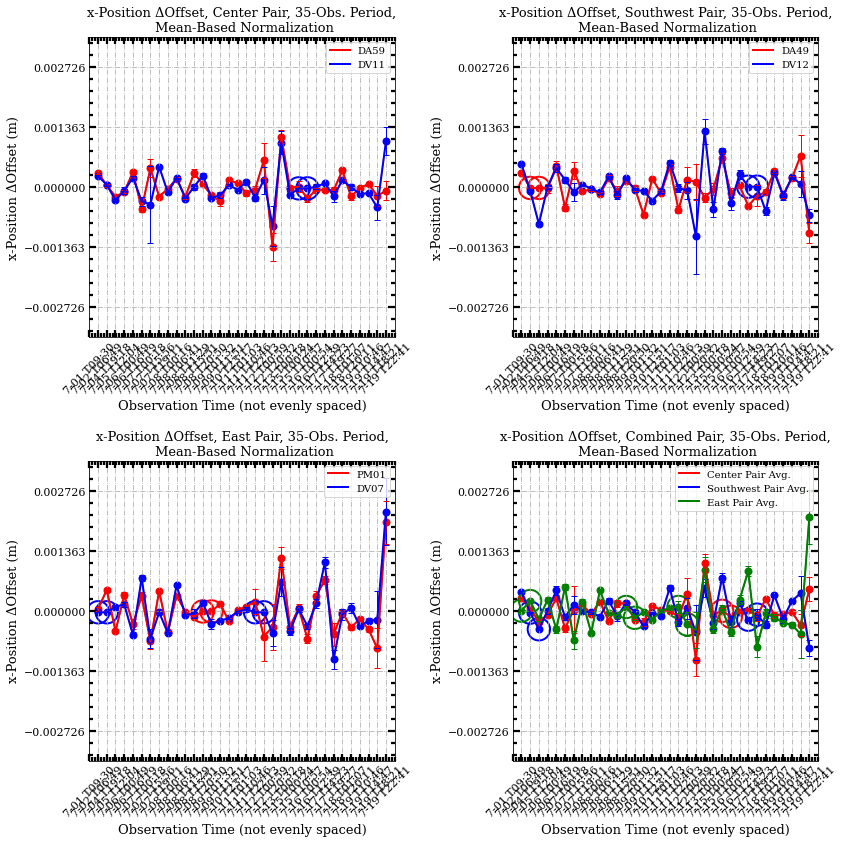

In [274]:
for i in range(names.shape[0]): 
    offset = np.average(delta[i,:,index])
    delta[i,:,index] = delta[i,:,index]-offset
    if probs[i,0,0] != "":
        for j in range(np.where(probs[i,:,0] == "")[0][0]):
            probs[i,j,index+1] = float(probs[i,j,index+1])-offset

maxima = np.empty((names.shape[0],1,2),dtype='float')
for i in range(names.shape[0]):
    maxima[i,0,0], maxima[i,0,1] = np.max((delta[i,:,index]+errors[i,:,index])), np.min((delta[i,:,index]-errors[i,:,index]))

deltaAvg = np.empty((int(names.shape[0]/2),numOfObs-1,3),dtype='float')
errorAvg = np.empty((int(names.shape[0]/2),numOfObs-1,3),dtype='float')
for i in range(3): 
    deltaAvg[i,:,:] = (delta[i*2,:,:]+delta[i*2+1,:,:])/2
    errorAvg[i,:,:] = (errors[i*2,:,:]+errors[i*2+1,:,:])/2
    
probsAvg = np.empty((int(names.shape[0]/2),numOfObs-1,4),dtype='U25')
temp = np.empty((1,4),dtype='U25')
for j in range(names.shape[0]):
    i = j // 2
    if probs[j,0,0] != "":
        for row in range(np.shape(probs[j,:np.where(probs[j,:,0] == "")[0][0],:])[0]):
            L = np.where(probsAvg[i,:,0] == "")[0][0]
            probsAvg[i,L,3] = probs[j,row,4]
            probsAvg[i,L,:3] = deltaAvg[i,int(probsAvg[i,L,3])-1,:]
            
for i in range(int(names.shape[0]/2)): deltaAvg[i,:,index] = deltaAvg[i,:,index]-np.average(deltaAvg[i,:,index])
        
xmin, xmax = 0, np.shape(times[0,:,:])[0]+1
ymax, ymin = np.max((maxima[:,0,0]))+0.0004, np.min((maxima[:,0,1]))-0.0004

if abs(ymax) > abs(ymin):
    ymin = -ymax
else:
    ymax = abs(ymin)

x = range(1,np.shape(times[0,:,:])[0]+1)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))

deltaitive = []
negative = []
for i in range(np.shape(deltaAvg[0,:,index])[0]):
    if deltaAvg[0,i,index] > 0: deltaitive.append(deltaAvg[0,i,index])
    else: negative.append(deltaAvg[0,i,index])
deltaitive = np.array(deltaitive,dtype='float')
negative = np.array(negative,dtype='float')
avg1 = (np.average(deltaitive)-np.average(negative))/2.0

########## Center Array
title=graph+'-Position ΔOffset, Center Pair, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization'
xlabel='Observation Time (not evenly spaced)'
ylabel=graph+'-Position ΔOffset (m)'

xMajors,xMinors = np.shape(times[0,:,:])[0],3
yMajors,yMinors = 5,5

ax1.plot(x,delta[0,:,index],color='r',linestyle='-',linewidth=2,label=names.iloc[0])
ax1.scatter(x,delta[0,:,index],color='r',linestyle='-',linewidth=2)
ax1.errorbar(x, delta[0,:,index], yerr=errors[0,:,index], ecolor='r', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[0,0,0] != "":
    for row in range(np.where(probs[0,:,0] == "")[0][0]):
        ax1.scatter(float(probs[0,row,4]),float(probs[0,row,index+1]),s=500,c='none',edgecolors='r',linestyle='-',linewidth=2)

ax1.plot(x,delta[1,:,index],color='b',linestyle='-',linewidth=2,label=names.iloc[1])
ax1.scatter(x,delta[1,:,index],color='b',linestyle='-',linewidth=2)
ax1.errorbar(x, delta[1,:,index], yerr=errors[1,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[1,0,0] != "":
    for row in range(np.where(probs[1,:,0] == "")[0][0]):
        ax1.scatter(float(probs[1,row,4]),float(probs[1,row,index+1]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=2)

plt.rc("font", size=16,family='serif')

ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
x_major_ticks = MultipleLocator((xmax - xmin) / xMajors)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax1.xaxis.set_major_locator(x_major_ticks)
ax1.yaxis.set_major_locator(y_major_ticks)
ax1.xaxis.set_minor_locator(x_minor_ticks)
ax1.yaxis.set_minor_locator(y_minor_ticks)
ax1.grid(True, linestyle='-.')
ax1.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax1.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax1.set_xticks(range(numOfObs))
ax1.set_xticklabels(dates)
ax1.set_xlabel(xlabel,fontsize=13)
ax1.set_ylabel(ylabel,fontsize=13)
ax1.set_title(title,fontsize=13)
ax1.tick_params('x', labelrotation=45)
plt.tight_layout()

ax1.legend(loc=1,fontsize=10)

########## Southwest Array
title=graph+'-Position ΔOffset, Southwest Pair, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization'
xlabel='Observation Time (not evenly spaced)'
ylabel=graph+'-Position ΔOffset (m)'

xMajors,xMinors = np.shape(times[0,:,:])[0],3
yMajors,yMinors = 5,5

ax2.plot(x,delta[2,:,index],color='r',linestyle='-',linewidth=2,label=names[2])
ax2.scatter(x,delta[2,:,index],color='r',linestyle='-',linewidth=2)
ax2.errorbar(x, delta[2,:,index], yerr=errors[2,:,index], ecolor='r', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[2,0,0] != "":
    for row in range(np.where(probs[2,:,0] == "")[0][0]):
        ax2.scatter(float(probs[2,row,4]),float(probs[2,row,index+1]),s=500,c='none',edgecolors='r',linestyle='-',linewidth=2)
        
ax2.plot(x,delta[3,:,index],color='b',linestyle='-',linewidth=2,label=names[3])
ax2.scatter(x,delta[3,:,index],color='b',linestyle='-',linewidth=2)
ax2.errorbar(x, delta[3,:,index], yerr=errors[3,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[3,0,0] != "":
    for row in range(np.where(probs[3,:,0] == "")[0][0]):
        ax2.scatter(float(probs[3,row,4]),float(probs[3,row,index+1]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=2)

plt.rc("font", size=16,family='serif')

ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
x_major_ticks = MultipleLocator((xmax - xmin) / xMajors)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax2.xaxis.set_major_locator(x_major_ticks)
ax2.yaxis.set_major_locator(y_major_ticks)
ax2.xaxis.set_minor_locator(x_minor_ticks)
ax2.yaxis.set_minor_locator(y_minor_ticks)
ax2.grid(True, linestyle='-.')
ax2.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax2.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax2.set_xticks(range(numOfObs))
ax2.set_xticklabels(dates)
ax2.set_xlabel(xlabel,fontsize=13)
ax2.set_ylabel(ylabel,fontsize=13)
ax2.set_title(title,fontsize=13)
ax2.tick_params('x', labelrotation=45)
plt.tight_layout()

ax2.legend(loc=1,fontsize=10)

########## East Array
title=graph+'-Position ΔOffset, East Pair, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization'
xlabel='Observation Time (not evenly spaced)'
ylabel=graph+'-Position ΔOffset (m)'

xMajors,xMinors = np.shape(times[0,:,:])[0],3
yMajors,yMinors = 5,5

ax3.plot(x,delta[4,:,index],color='r',linestyle='-',linewidth=2,label=names[4])
ax3.scatter(x,delta[4,:,index],color='r',linestyle='-',linewidth=2)
ax3.errorbar(x, delta[4,:,index], yerr=errors[4,:,index], ecolor='r', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[4,0,0] != "":
    for row in range(np.where(probs[4,:,0] == "")[0][0]):
        ax3.scatter(float(probs[4,row,4]),float(probs[4,row,index+1]),s=500,c='none',edgecolors='r',linestyle='-',linewidth=2)
        
ax3.plot(x,delta[5,:,index],color='b',linestyle='-',linewidth=2,label=names[5])
ax3.scatter(x,delta[5,:,index],color='b',linestyle='-',linewidth=2)
ax3.errorbar(x, delta[5,:,index], yerr=errors[5,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[5,0,0] != "":
    for row in range(np.where(probs[5,:,0] == "")[0][0]):
        ax3.scatter(float(probs[5,row,4]),float(probs[5,row,index+1]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=2)

plt.rc("font", size=16,family='serif')

ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
x_major_ticks = MultipleLocator((xmax - xmin) / xMajors)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax3.xaxis.set_major_locator(x_major_ticks)
ax3.yaxis.set_major_locator(y_major_ticks)
ax3.xaxis.set_minor_locator(x_minor_ticks)
ax3.yaxis.set_minor_locator(y_minor_ticks)
ax3.grid(True, linestyle='-.')
ax3.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax3.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax3.set_xticks(range(numOfObs))
ax3.set_xticklabels(dates)
ax3.set_xlabel(xlabel,fontsize=13)
ax3.set_ylabel(ylabel,fontsize=13)
ax3.set_title(title,fontsize=13)
ax3.tick_params('x', labelrotation=45)
plt.tight_layout()

ax3.legend(loc=1,fontsize=10)

########## Combined Array
title=graph+'-Position ΔOffset, Combined Pair, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization'
xlabel='Observation Time (not evenly spaced)'
ylabel=graph+'-Position ΔOffset (m)'

xMajors,xMinors = np.shape(times[0,:,:])[0],3
yMajors,yMinors = 5,5

ax4.plot(x,deltaAvg[0,:,index],color='r',linestyle='-',linewidth=2,label="Center Pair Avg.")
ax4.scatter(x,deltaAvg[0,:,index],color='r',linestyle='-',linewidth=2)
ax4.errorbar(x,deltaAvg[0,:,index], yerr=errorAvg[0,:,index], ecolor='r', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probsAvg[0,0,0] != "":
    for row in range(np.where(probsAvg[0,:,:] == "")[0][0]):
        ax4.scatter(float(probsAvg[0,row,3]),float(probsAvg[0,row,index]),s=500,c='none',edgecolors='r',linestyle='-',linewidth=2)

ax4.plot(x,deltaAvg[1,:,index],color='b',linestyle='-',linewidth=2,label="Southwest Pair Avg.")
ax4.scatter(x,deltaAvg[1,:,index],color='b',linestyle='-',linewidth=2)
ax4.errorbar(x,deltaAvg[1,:,index], yerr=errorAvg[1,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probsAvg[1,0,0] != "":
    for row in range(np.where(probsAvg[1,:,:] == "")[0][0]):
        ax4.scatter(float(probsAvg[1,row,3]),float(probsAvg[1,row,index]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=2)

ax4.plot(x,deltaAvg[2,:,index],color='g',linestyle='-',linewidth=2,label="East Pair Avg.")
ax4.scatter(x,deltaAvg[2,:,index],color='g',linestyle='-',linewidth=2)
ax4.errorbar(x,deltaAvg[2,:,index], yerr=errorAvg[2,:,index], ecolor='g', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probsAvg[2,0,0] != "":
    for row in range(np.where(probsAvg[2,:,:] == "")[0][0]):
        ax4.scatter(float(probsAvg[2,row,3]),float(probsAvg[2,row,index]),s=500,c='none',edgecolors='g',linestyle='-',linewidth=2)

plt.rc("font", size=16,family='serif')

ax4.set_xlim(xmin,xmax)
ax4.set_ylim(ymin,ymax)
x_major_ticks = MultipleLocator((xmax - xmin) / xMajors)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax4.xaxis.set_major_locator(x_major_ticks)
ax4.yaxis.set_major_locator(y_major_ticks)
ax4.xaxis.set_minor_locator(x_minor_ticks)
ax4.yaxis.set_minor_locator(y_minor_ticks)
ax4.grid(True, linestyle='-.')
ax4.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax4.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax4.set_xticks(range(numOfObs))
ax4.set_xticklabels(dates)
ax4.set_xlabel(xlabel,fontsize=13)
ax4.set_ylabel(ylabel,fontsize=13)
ax4.set_title(title,fontsize=13)
ax4.tick_params('x', labelrotation=45)
plt.tight_layout()

ax4.legend(loc=1,fontsize=10)

plt.show()
#plt.savefig(directory+'offsetplots/deltaoffset'+graph.capitalize()+'.png', bbox_inches='tight')
#plt.close()

#'''

# delta vs. delta w/ mean-based normalization

In [307]:
directory = '/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/'

weaArr = pd.read_csv(directory+nearestWeatherStation(refants[0:2])+'.csv').to_numpy(dtype='float')

numOfObs = np.shape(weaArr)[0]

probs1 = np.zeros((numOfObs-1,1),dtype='float')
probs2 = np.zeros((numOfObs,1),dtype='float')
data1 = np.empty((numOfObs-1,6),dtype='float')
data2 = np.empty((numOfObs,6),dtype='float')
    
k = 0
for row in range(1,numOfObs):
    if weaArr[row,:].any() == 0 or weaArr[row-1,:].any() == 0:
        data1[row-1,:] = 0
        probs1[k,0] = row-1
        k += 1
    else:
        data1[row-1,:] = weaArr[row,4:10]-weaArr[row-1,4:10]
        
for i in range(np.shape(data1[0,:])[0]):
    offset = np.average(data1[:,i])
    data1[:,i] = data1[:,i]-offset
        
avg2 = np.empty(np.shape(data1[0,:])[0],dtype='float')
for i in range(np.shape(data1[0,:])[0]):
    deltaitive = []
    negative = []
    for j in range(np.shape(data1[:,i])[0]):
        if data1[j,i] > 0: deltaitive.append(data1[j,i])
        else: negative.append(data1[j,i])
    deltaitive = np.array(deltaitive,dtype='float')
    negative = np.array(negative,dtype='float')
    
    avg2[i] = (np.average(deltaitive)-np.average(negative))/2.0

for i in range(np.shape(data1[0,:])[0]): data1[:,i] = data1[:,i] / (avg2[i]/avg1)

maxima1 = np.empty((1,2),dtype='float')
maxima1[0,0], maxima1[0,1] = max(np.max(data1[:,:]),np.max(posAvg[0,:,index]+errorAvg[0,:,index])), min(np.max(data1[:,:]),np.max(posAvg[0,:,index]-errorAvg[0,:,index]))

###########

k = 0
for row in range(numOfObs):
    if weaArr[row,:].any() == 0:
        data2[row,:] = 0
        probs2[k,0] = row
        k += 1
    else:
        data2[row,:] = weaArr[row,4:10]
        
for i in range(np.shape(data2[0,:])[0]):
    offset = np.average(data2[:,i])
    data2[:,i] = data2[:,i]-offset
        
avg2 = np.empty(np.shape(data2[0,:])[0],dtype='float')
for i in range(np.shape(data2[0,:])[0]):
    deltaitive = []
    negative = []
    for j in range(np.shape(data2[:,i])[0]):
        if data2[j,i] > 0: deltaitive.append(data2[j,i])
        else: negative.append(data2[j,i])
    deltaitive = np.array(deltaitive,dtype='float')
    
    if negative != []:
        negative = np.array(negative,dtype='float')
        avg2[i] = (np.average(deltaitive)-np.average(negative))/2.0
    else: avg2[i] = (np.average(deltaitive))
        
for i in range(np.shape(data2[0,:])[0]): 
    data2[:,i] = data2[:,i] / (avg2[i]/avg1)

maxima2 = np.empty((1,2),dtype='float')
maxima2[0,0], maxima2[0,1] = max(np.max(data2[:,:]),np.max(posAvg[0,:,index]+errorAvg[0,:,index])), min(np.max(data2[:,:]),np.max(posAvg[0,:,index]-errorAvg[0,:,index]))

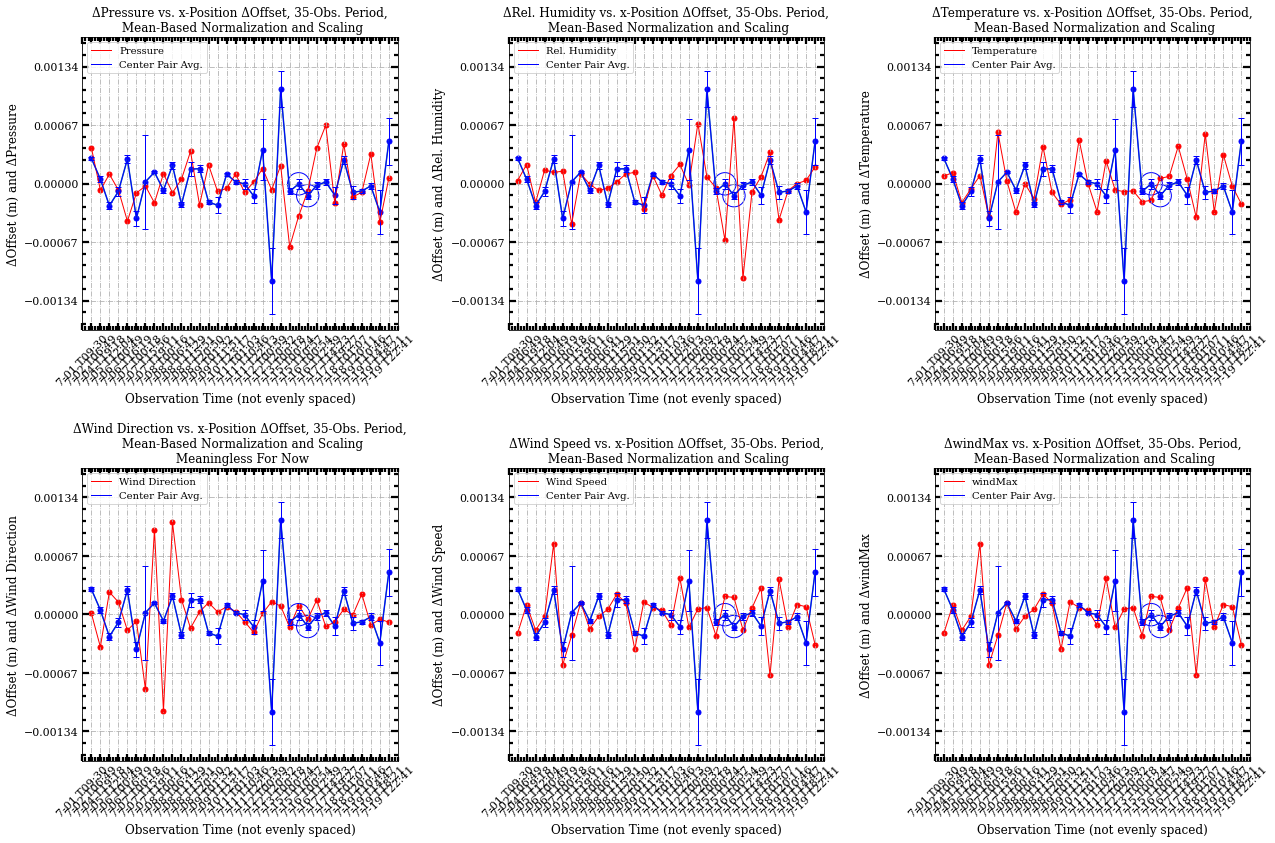

In [308]:
xmin, xmax = 0, numOfObs
ymax, ymin = maxima1[0,0]+abs(maxima1[0,0]*0.3), maxima1[0,1]-abs(maxima1[0,1]*0.3)

if abs(ymax) > abs(ymin):
    ymin = -ymax
else:
    ymax = abs(ymin)
    
x = range(1,numOfObs)

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(18,12))

########## Pressure
datum = 'Pressure'
weaIndex = 0

title='Δ'+datum+' vs. '+graph+'-Position ΔOffset, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization and Scaling'
xlabel='Observation Time (not evenly spaced)'
ylabel='ΔOffset (m) and Δ'+datum

xMajors,xMinors = 3,3
yMajors,yMinors = 5,5

ax1.plot(x,data1[:,weaIndex],color='r',linestyle='-',linewidth=1,label=datum)
ax1.scatter(x,data1[:,weaIndex],s=25,color='r',linestyle='-',linewidth=1)

ax1.plot(x,deltaAvg[0,:,index],color='b',linestyle='-',linewidth=1,label="Center Pair Avg.")
ax1.scatter(x,deltaAvg[0,:,index],s=25,color='b',linestyle='-',linewidth=1)
ax1.errorbar(x,deltaAvg[0,:,index], yerr=errorAvg[0,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs1[0] != 0:
    for row in range(np.where(probs1[:] != 0)[0][0]):
        ax1.scatter(probs1[row,0],0,s=500,c='none',edgecolors='r',linestyle='-',linewidth=1)
        

if probsAvg[0,0,0] != "":
    for row in range(np.where(probsAvg[0,:,:] == "")[0][0]):
        ax1.scatter(float(probsAvg[0,row,3]),float(probsAvg[0,row,index]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=1)

plt.rc("font", size=16,family='serif')

ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax1.yaxis.set_major_locator(y_major_ticks)
ax1.xaxis.set_minor_locator(x_minor_ticks)
ax1.yaxis.set_minor_locator(y_minor_ticks)
ax1.grid(True, linestyle='-.')
ax1.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax1.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax1.set_xticks(range(numOfObs))
ax1.set_xticklabels(dates)
ax1.set_xlabel(xlabel,fontsize=12)
ax1.set_ylabel(ylabel,fontsize=12)
ax1.set_title(title,fontsize=12)
ax1.tick_params('x', labelrotation=45)
plt.tight_layout()

ax1.legend(loc=2,fontsize=10)

########## Relative Humidity
datum = 'Rel. Humidity'
weaIndex = 1

title='Δ'+datum+' vs. '+graph+'-Position ΔOffset, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization and Scaling'
xlabel='Observation Time (not evenly spaced)'
ylabel='ΔOffset (m) and Δ'+datum

xMajors,xMinors = 3,3
yMajors,yMinors = 5,5

ax2.plot(x,data1[:,weaIndex],color='r',linestyle='-',linewidth=1,label=datum)
ax2.scatter(x,data1[:,weaIndex],s=25,color='r',linestyle='-',linewidth=1)

ax2.plot(x,deltaAvg[0,:,index],color='b',linestyle='-',linewidth=1,label="Center Pair Avg.")
ax2.scatter(x,deltaAvg[0,:,index],s=25,color='b',linestyle='-',linewidth=1)
ax2.errorbar(x,deltaAvg[0,:,index], yerr=errorAvg[0,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs1[0] != 0:
    for row in range(np.where(probs1[:] != 0)[0][0]):
        ax2.scatter(probs1[row,0],0,s=500,c='none',edgecolors='r',linestyle='-',linewidth=1)
        

if probsAvg[0,0,0] != "":
    for row in range(np.where(probsAvg[0,:,:] == "")[0][0]):
        ax2.scatter(float(probsAvg[0,row,3]),float(probsAvg[0,row,index]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=1)

plt.rc("font", size=16,family='serif')

ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax2.yaxis.set_major_locator(y_major_ticks)
ax2.xaxis.set_minor_locator(x_minor_ticks)
ax2.yaxis.set_minor_locator(y_minor_ticks)
ax2.grid(True, linestyle='-.')
ax2.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax2.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax2.set_xticks(range(numOfObs))
ax2.set_xticklabels(dates)
ax2.set_xlabel(xlabel,fontsize=12)
ax2.set_ylabel(ylabel,fontsize=12)
ax2.set_title(title,fontsize=12)
ax2.tick_params('x', labelrotation=45)
plt.tight_layout()

ax2.legend(loc=2,fontsize=10)

########## Temperature
datum = 'Temperature'
weaIndex = 2

title='Δ'+datum+' vs. '+graph+'-Position ΔOffset, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization and Scaling'
xlabel='Observation Time (not evenly spaced)'
ylabel='ΔOffset (m) and Δ'+datum

xMajors,xMinors = 3,3
yMajors,yMinors = 5,5

ax3.plot(x,data1[:,weaIndex],color='r',linestyle='-',linewidth=1,label=datum)
ax3.scatter(x,data1[:,weaIndex],s=25,color='r',linestyle='-',linewidth=1)

ax3.plot(x,deltaAvg[0,:,index],color='b',linestyle='-',linewidth=1,label="Center Pair Avg.")
ax3.scatter(x,deltaAvg[0,:,index],s=25,color='b',linestyle='-',linewidth=1)
ax3.errorbar(x,deltaAvg[0,:,index], yerr=errorAvg[0,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs1[0] != 0:
    for row in range(np.where(probs1[:] != 0)[0][0]):
        ax3.scatter(probs1[row,0],0,s=500,c='none',edgecolors='r',linestyle='-',linewidth=1)
        

if probsAvg[0,0,0] != "":
    for row in range(np.where(probsAvg[0,:,:] == "")[0][0]):
        ax3.scatter(float(probsAvg[0,row,3]),float(probsAvg[0,row,index]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=1)

plt.rc("font", size=16,family='serif')

ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax3.yaxis.set_major_locator(y_major_ticks)
ax3.xaxis.set_minor_locator(x_minor_ticks)
ax3.yaxis.set_minor_locator(y_minor_ticks)
ax3.grid(True, linestyle='-.')
ax3.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax3.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax3.set_xticks(range(numOfObs))
ax3.set_xticklabels(dates)
ax3.set_xlabel(xlabel,fontsize=12)
ax3.set_ylabel(ylabel,fontsize=12)
ax3.set_title(title,fontsize=12)
ax3.tick_params('x', labelrotation=45)
plt.tight_layout()

ax3.legend(loc=2,fontsize=10)

########## Wind Direction
datum = 'Wind Direction'
weaIndex = 3

title='Δ'+datum+' vs. '+graph+'-Position ΔOffset, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization and Scaling\n Meaningless For Now'
xlabel='Observation Time (not evenly spaced)'
ylabel='ΔOffset (m) and Δ'+datum

xMajors,xMinors = 3,3
yMajors,yMinors = 5,5

ax4.plot(x,data1[:,weaIndex],color='r',linestyle='-',linewidth=1,label=datum)
ax4.scatter(x,data1[:,weaIndex],s=25,color='r',linestyle='-',linewidth=1)

ax4.plot(x,deltaAvg[0,:,index],color='b',linestyle='-',linewidth=1,label="Center Pair Avg.")
ax4.scatter(x,deltaAvg[0,:,index],s=25,color='b',linestyle='-',linewidth=1)
ax4.errorbar(x,deltaAvg[0,:,index], yerr=errorAvg[0,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs1[0] != 0:
    for row in range(np.where(probs1[:] != 0)[0][0]):
        ax4.scatter(probs1[row,0],0,s=500,c='none',edgecolors='r',linestyle='-',linewidth=1)
        

if probsAvg[0,0,0] != "":
    for row in range(np.where(probsAvg[0,:,:] == "")[0][0]):
        ax4.scatter(float(probsAvg[0,row,3]),float(probsAvg[0,row,index]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=1)

plt.rc("font", size=16,family='serif')

ax4.set_xlim(xmin,xmax)
ax4.set_ylim(ymin,ymax)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax4.yaxis.set_major_locator(y_major_ticks)
ax4.xaxis.set_minor_locator(x_minor_ticks)
ax4.yaxis.set_minor_locator(y_minor_ticks)
ax4.grid(True, linestyle='-.')
ax4.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax4.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax4.set_xticks(range(numOfObs))
ax4.set_xticklabels(dates)
ax4.set_xlabel(xlabel,fontsize=12)
ax4.set_ylabel(ylabel,fontsize=12)
ax4.set_title(title,fontsize=12)
ax4.tick_params('x', labelrotation=45)
plt.tight_layout()

ax4.legend(loc=2,fontsize=10)

########## Wind Speed
datum = 'Wind Speed'
weaIndex = 4

title='Δ'+datum+' vs. '+graph+'-Position ΔOffset, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization and Scaling'
xlabel='Observation Time (not evenly spaced)'
ylabel='ΔOffset (m) and Δ'+datum

xMajors,xMinors = 3,3
yMajors,yMinors = 5,5

ax5.plot(x,data1[:,weaIndex],color='r',linestyle='-',linewidth=1,label=datum)
ax5.scatter(x,data1[:,weaIndex],s=25,color='r',linestyle='-',linewidth=1)

ax5.plot(x,deltaAvg[0,:,index],color='b',linestyle='-',linewidth=1,label="Center Pair Avg.")
ax5.scatter(x,deltaAvg[0,:,index],s=25,color='b',linestyle='-',linewidth=1)
ax5.errorbar(x,deltaAvg[0,:,index], yerr=errorAvg[0,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs1[0] != 0:
    for row in range(np.where(probs1[:] != 0)[0][0]):
        ax5.scatter(probs1[row,0],0,s=500,c='none',edgecolors='r',linestyle='-',linewidth=1)
        

if probsAvg[0,0,0] != "":
    for row in range(np.where(probsAvg[0,:,:] == "")[0][0]):
        ax5.scatter(float(probsAvg[0,row,3]),float(probsAvg[0,row,index]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=1)

plt.rc("font", size=16,family='serif')

ax5.set_xlim(xmin,xmax)
ax5.set_ylim(ymin,ymax)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax5.yaxis.set_major_locator(y_major_ticks)
ax5.xaxis.set_minor_locator(x_minor_ticks)
ax5.yaxis.set_minor_locator(y_minor_ticks)
ax5.grid(True, linestyle='-.')
ax5.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax5.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax5.set_xticks(range(numOfObs))
ax5.set_xticklabels(dates)
ax5.set_xlabel(xlabel,fontsize=12)
ax5.set_ylabel(ylabel,fontsize=12)
ax5.set_title(title,fontsize=12)
ax5.tick_params('x', labelrotation=45)
plt.tight_layout()

ax5.legend(loc=2,fontsize=10)

########## windMax
datum = 'windMax'
weaIndex = 5

title='Δ'+datum+' vs. '+graph+'-Position ΔOffset, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization and Scaling'
xlabel='Observation Time (not evenly spaced)'
ylabel='ΔOffset (m) and Δ'+datum

xMajors,xMinors = 3,3
yMajors,yMinors = 5,5

ax6.plot(x,data1[:,weaIndex],color='r',linestyle='-',linewidth=1,label=datum)
ax6.scatter(x,data1[:,weaIndex],s=25,color='r',linestyle='-',linewidth=1)

ax6.plot(x,deltaAvg[0,:,index],color='b',linestyle='-',linewidth=1,label="Center Pair Avg.")
ax6.scatter(x,deltaAvg[0,:,index],s=25,color='b',linestyle='-',linewidth=1)
ax6.errorbar(x,deltaAvg[0,:,index], yerr=errorAvg[0,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs1[0] != 0:
    for row in range(np.where(probs1[:] != 0)[0][0]):
        ax6.scatter(probs1[row,0],0,s=500,c='none',edgecolors='r',linestyle='-',linewidth=1)
        

if probsAvg[0,0,0] != "":
    for row in range(np.where(probsAvg[0,:,:] == "")[0][0]):
        ax6.scatter(float(probsAvg[0,row,3]),float(probsAvg[0,row,index]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=1)

plt.rc("font", size=16,family='serif')

ax6.set_xlim(xmin,xmax)
ax6.set_ylim(ymin,ymax)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax6.yaxis.set_major_locator(y_major_ticks)
ax6.xaxis.set_minor_locator(x_minor_ticks)
ax6.yaxis.set_minor_locator(y_minor_ticks)
ax6.grid(True, linestyle='-.')
ax6.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax6.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax6.set_xticks(range(numOfObs))
ax6.set_xticklabels(dates)
ax6.set_xlabel(xlabel,fontsize=12)
ax6.set_ylabel(ylabel,fontsize=12)
ax6.set_title(title,fontsize=12)
ax6.tick_params('x', labelrotation=45)
plt.tight_layout()

ax6.legend(loc=2,fontsize=10)


#################################################################################################################

plt.show()
#plt.savefig(directory+'offsetplots/deltaweather'+graph.capitalize()+'.png', bbox_inches='tight')
#plt.close()

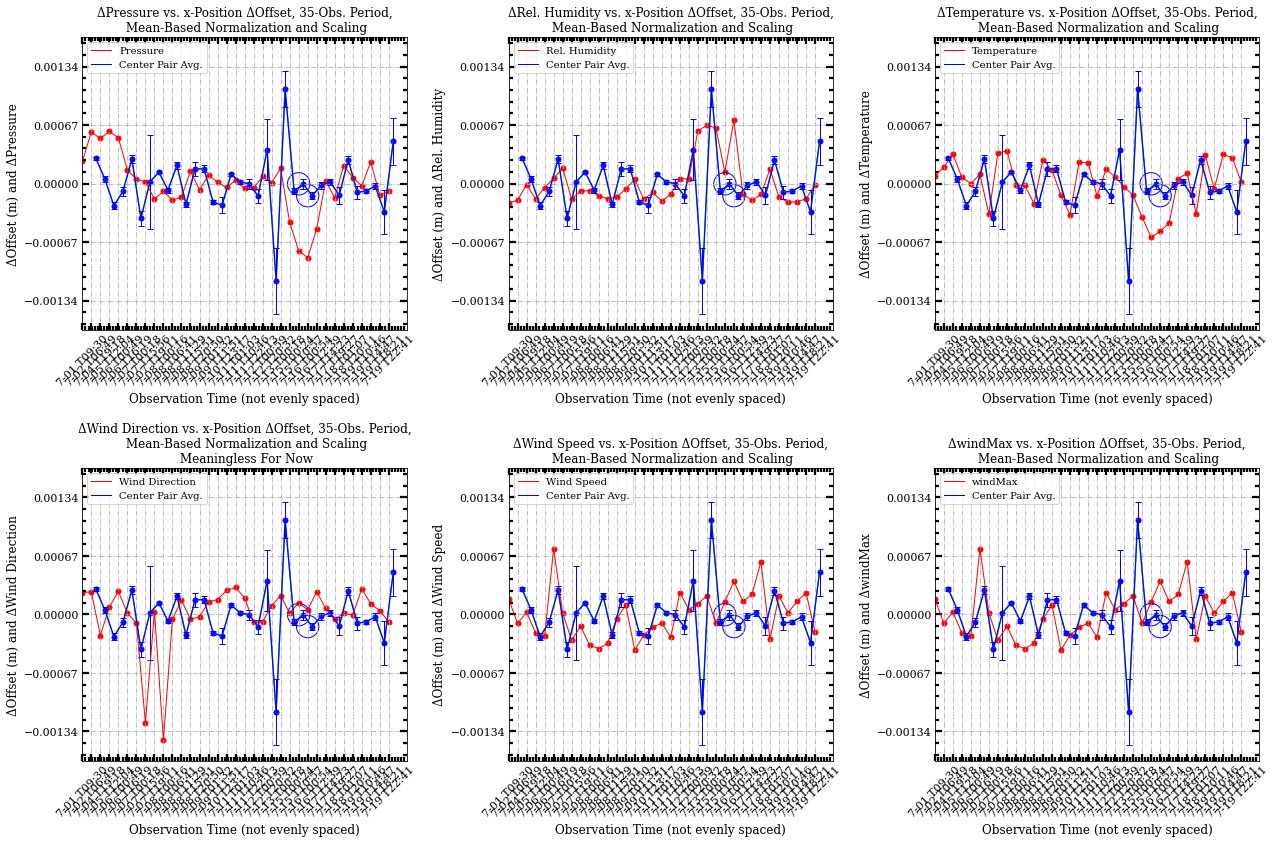

In [309]:
xmin, xmax = 0, numOfObs+1
ymax, ymin = maxima2[0,0]+abs(maxima2[0,0]*0.3), maxima2[0,1]-abs(maxima2[0,1]*0.3)

if abs(ymax) > abs(ymin):
    ymin = -ymax
else:
    ymax = abs(ymin)
    
x2 = range(numOfObs)
x1 = np.array(range(1,numOfObs),dtype='float')+0.5

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(18,12))

########## Pressure
datum = 'Pressure'
weaIndex = 0

title='Δ'+datum+' vs. '+graph+'-Position ΔOffset, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization and Scaling'
xlabel='Observation Time (not evenly spaced)'
ylabel='ΔOffset (m) and Δ'+datum

xMajors,xMinors = 3,3
yMajors,yMinors = 5,5

ax1.plot(x2,data2[:,weaIndex],color='r',linestyle='-',linewidth=1,label=datum)
ax1.scatter(x2,data2[:,weaIndex],s=25,color='r',linestyle='-',linewidth=1)

ax1.plot(x1,deltaAvg[0,:,index],color='b',linestyle='-',linewidth=1,label="Center Pair Avg.")
ax1.scatter(x1,deltaAvg[0,:,index],s=25,color='b',linestyle='-',linewidth=1)
ax1.errorbar(x1,deltaAvg[0,:,index], yerr=errorAvg[0,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[0] != 0:
    for row in range(np.where(probs[:] != 0)[0][0]):
        ax1.scatter(probs[row,0],0,s=500,c='none',edgecolors='r',linestyle='-',linewidth=1)
        

if probsAvg[0,0,0] != "":
    for row in range(np.where(probsAvg[0,:,:] == "")[0][0]):
        ax1.scatter(float(probsAvg[0,row,3]),float(probsAvg[0,row,index]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=1)

plt.rc("font", size=16,family='serif')

ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax1.yaxis.set_major_locator(y_major_ticks)
ax1.xaxis.set_minor_locator(x_minor_ticks)
ax1.yaxis.set_minor_locator(y_minor_ticks)
ax1.grid(True, linestyle='-.')
ax1.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax1.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax1.set_xticks(range(numOfObs))
ax1.set_xticklabels(dates)
ax1.set_xlabel(xlabel,fontsize=12)
ax1.set_ylabel(ylabel,fontsize=12)
ax1.set_title(title,fontsize=12)
ax1.tick_params('x', labelrotation=45)
plt.tight_layout()

ax1.legend(loc=2,fontsize=10)

########## Relative Humidity
datum = 'Rel. Humidity'
weaIndex = 1

title='Δ'+datum+' vs. '+graph+'-Position ΔOffset, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization and Scaling'
xlabel='Observation Time (not evenly spaced)'
ylabel='ΔOffset (m) and Δ'+datum

xMajors,xMinors = 3,3
yMajors,yMinors = 5,5

ax2.plot(x2,data2[:,weaIndex],color='r',linestyle='-',linewidth=1,label=datum)
ax2.scatter(x2,data2[:,weaIndex],s=25,color='r',linestyle='-',linewidth=1)

ax2.plot(x1,deltaAvg[0,:,index],color='b',linestyle='-',linewidth=1,label="Center Pair Avg.")
ax2.scatter(x1,deltaAvg[0,:,index],s=25,color='b',linestyle='-',linewidth=1)
ax2.errorbar(x1,deltaAvg[0,:,index], yerr=errorAvg[0,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[0] != 0:
    for row in range(np.where(probs[:] != 0)[0][0]):
        ax2.scatter(probs[row,0],0,s=500,c='none',edgecolors='r',linestyle='-',linewidth=1)
        

if probsAvg[0,0,0] != "":
    for row in range(np.where(probsAvg[0,:,:] == "")[0][0]):
        ax2.scatter(float(probsAvg[0,row,3]),float(probsAvg[0,row,index]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=1)

plt.rc("font", size=16,family='serif')

ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax2.yaxis.set_major_locator(y_major_ticks)
ax2.xaxis.set_minor_locator(x_minor_ticks)
ax2.yaxis.set_minor_locator(y_minor_ticks)
ax2.grid(True, linestyle='-.')
ax2.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax2.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax2.set_xticks(range(numOfObs))
ax2.set_xticklabels(dates)
ax2.set_xlabel(xlabel,fontsize=12)
ax2.set_ylabel(ylabel,fontsize=12)
ax2.set_title(title,fontsize=12)
ax2.tick_params('x', labelrotation=45)
plt.tight_layout()

ax2.legend(loc=2,fontsize=10)

########## Temperature
datum = 'Temperature'
weaIndex = 2

title='Δ'+datum+' vs. '+graph+'-Position ΔOffset, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization and Scaling'
xlabel='Observation Time (not evenly spaced)'
ylabel='ΔOffset (m) and Δ'+datum

xMajors,xMinors = 3,3
yMajors,yMinors = 5,5

ax3.plot(x2,data2[:,weaIndex],color='r',linestyle='-',linewidth=1,label=datum)
ax3.scatter(x2,data2[:,weaIndex],s=25,color='r',linestyle='-',linewidth=1)

ax3.plot(x1,deltaAvg[0,:,index],color='b',linestyle='-',linewidth=1,label="Center Pair Avg.")
ax3.scatter(x1,deltaAvg[0,:,index],s=25,color='b',linestyle='-',linewidth=1)
ax3.errorbar(x1,deltaAvg[0,:,index], yerr=errorAvg[0,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[0] != 0:
    for row in range(np.where(probs[:] != 0)[0][0]):
        ax3.scatter(probs[row,0],0,s=500,c='none',edgecolors='r',linestyle='-',linewidth=1)
        

if probsAvg[0,0,0] != "":
    for row in range(np.where(probsAvg[0,:,:] == "")[0][0]):
        ax3.scatter(float(probsAvg[0,row,3]),float(probsAvg[0,row,index]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=1)

plt.rc("font", size=16,family='serif')

ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax3.yaxis.set_major_locator(y_major_ticks)
ax3.xaxis.set_minor_locator(x_minor_ticks)
ax3.yaxis.set_minor_locator(y_minor_ticks)
ax3.grid(True, linestyle='-.')
ax3.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax3.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax3.set_xticks(range(numOfObs))
ax3.set_xticklabels(dates)
ax3.set_xlabel(xlabel,fontsize=12)
ax3.set_ylabel(ylabel,fontsize=12)
ax3.set_title(title,fontsize=12)
ax3.tick_params('x', labelrotation=45)
plt.tight_layout()

ax3.legend(loc=2,fontsize=10)

########## Wind Direction
datum = 'Wind Direction'
weaIndex = 3

title='Δ'+datum+' vs. '+graph+'-Position ΔOffset, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization and Scaling\n Meaningless For Now'
xlabel='Observation Time (not evenly spaced)'
ylabel='ΔOffset (m) and Δ'+datum

xMajors,xMinors = 3,3
yMajors,yMinors = 5,5

ax4.plot(x2,data2[:,weaIndex],color='r',linestyle='-',linewidth=1,label=datum)
ax4.scatter(x2,data2[:,weaIndex],s=25,color='r',linestyle='-',linewidth=1)

ax4.plot(x1,deltaAvg[0,:,index],color='b',linestyle='-',linewidth=1,label="Center Pair Avg.")
ax4.scatter(x1,deltaAvg[0,:,index],s=25,color='b',linestyle='-',linewidth=1)
ax4.errorbar(x1,deltaAvg[0,:,index], yerr=errorAvg[0,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[0] != 0:
    for row in range(np.where(probs[:] != 0)[0][0]):
        ax4.scatter(probs[row,0],0,s=500,c='none',edgecolors='r',linestyle='-',linewidth=1)
        

if probsAvg[0,0,0] != "":
    for row in range(np.where(probsAvg[0,:,:] == "")[0][0]):
        ax4.scatter(float(probsAvg[0,row,3]),float(probsAvg[0,row,index]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=1)

plt.rc("font", size=16,family='serif')

ax4.set_xlim(xmin,xmax)
ax4.set_ylim(ymin,ymax)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax4.yaxis.set_major_locator(y_major_ticks)
ax4.xaxis.set_minor_locator(x_minor_ticks)
ax4.yaxis.set_minor_locator(y_minor_ticks)
ax4.grid(True, linestyle='-.')
ax4.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax4.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax4.set_xticks(range(numOfObs))
ax4.set_xticklabels(dates)
ax4.set_xlabel(xlabel,fontsize=12)
ax4.set_ylabel(ylabel,fontsize=12)
ax4.set_title(title,fontsize=12)
ax4.tick_params('x', labelrotation=45)
plt.tight_layout()

ax4.legend(loc=2,fontsize=10)

########## Wind Speed
datum = 'Wind Speed'
weaIndex = 4

title='Δ'+datum+' vs. '+graph+'-Position ΔOffset, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization and Scaling'
xlabel='Observation Time (not evenly spaced)'
ylabel='ΔOffset (m) and Δ'+datum

xMajors,xMinors = 3,3
yMajors,yMinors = 5,5

ax5.plot(x2,data2[:,weaIndex],color='r',linestyle='-',linewidth=1,label=datum)
ax5.scatter(x2,data2[:,weaIndex],s=25,color='r',linestyle='-',linewidth=1)

ax5.plot(x1,deltaAvg[0,:,index],color='b',linestyle='-',linewidth=1,label="Center Pair Avg.")
ax5.scatter(x1,deltaAvg[0,:,index],s=25,color='b',linestyle='-',linewidth=1)
ax5.errorbar(x1,deltaAvg[0,:,index], yerr=errorAvg[0,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[0] != 0:
    for row in range(np.where(probs[:] != 0)[0][0]):
        ax5.scatter(probs[row,0],0,s=500,c='none',edgecolors='r',linestyle='-',linewidth=1)
        

if probsAvg[0,0,0] != "":
    for row in range(np.where(probsAvg[0,:,:] == "")[0][0]):
        ax5.scatter(float(probsAvg[0,row,3]),float(probsAvg[0,row,index]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=1)

plt.rc("font", size=16,family='serif')

ax5.set_xlim(xmin,xmax)
ax5.set_ylim(ymin,ymax)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax5.yaxis.set_major_locator(y_major_ticks)
ax5.xaxis.set_minor_locator(x_minor_ticks)
ax5.yaxis.set_minor_locator(y_minor_ticks)
ax5.grid(True, linestyle='-.')
ax5.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax5.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax5.set_xticks(range(numOfObs))
ax5.set_xticklabels(dates)
ax5.set_xlabel(xlabel,fontsize=12)
ax5.set_ylabel(ylabel,fontsize=12)
ax5.set_title(title,fontsize=12)
ax5.tick_params('x', labelrotation=45)
plt.tight_layout()

ax5.legend(loc=2,fontsize=10)

########## windMax
datum = 'windMax'
weaIndex = 5

title='Δ'+datum+' vs. '+graph+'-Position ΔOffset, '+str(numOfObs)+'-Obs. Period,\n Mean-Based Normalization and Scaling'
xlabel='Observation Time (not evenly spaced)'
ylabel='ΔOffset (m) and Δ'+datum

xMajors,xMinors = 3,3
yMajors,yMinors = 5,5

ax6.plot(x2,data2[:,weaIndex],color='r',linestyle='-',linewidth=1,label=datum)
ax6.scatter(x2,data2[:,weaIndex],s=25,color='r',linestyle='-',linewidth=1)

ax6.plot(x1,deltaAvg[0,:,index],color='b',linestyle='-',linewidth=1,label="Center Pair Avg.")
ax6.scatter(x1,deltaAvg[0,:,index],s=25,color='b',linestyle='-',linewidth=1)
ax6.errorbar(x1,deltaAvg[0,:,index], yerr=errorAvg[0,:,index], ecolor='b', elinewidth=1, capsize=3, barsabove=True, capthick=None)

if probs[0] != 0:
    for row in range(np.where(probs[:] != 0)[0][0]):
        ax6.scatter(probs[row,0],0,s=500,c='none',edgecolors='r',linestyle='-',linewidth=1)
        

if probsAvg[0,0,0] != "":
    for row in range(np.where(probsAvg[0,:,:] == "")[0][0]):
        ax6.scatter(float(probsAvg[0,row,3]),float(probsAvg[0,row,index]),s=500,c='none',edgecolors='b',linestyle='-',linewidth=1)

plt.rc("font", size=16,family='serif')

ax6.set_xlim(xmin,xmax)
ax6.set_ylim(ymin,ymax)
y_major_ticks = MultipleLocator((ymax - ymin) / yMajors)
y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
ax6.yaxis.set_major_locator(y_major_ticks)
ax6.xaxis.set_minor_locator(x_minor_ticks)
ax6.yaxis.set_minor_locator(y_minor_ticks)
ax6.grid(True, linestyle='-.')
ax6.tick_params(which='major',axis='both',direction='in',length=7,width=2.25,top=True,right=True,labelsize=11)
ax6.tick_params(which='minor',axis='both',direction='in',length=4,width=2.25,top=True,right=True,labelsize=11)
ax6.set_xticks(range(numOfObs))
ax6.set_xticklabels(dates)
ax6.set_xlabel(xlabel,fontsize=12)
ax6.set_ylabel(ylabel,fontsize=12)
ax6.set_title(title,fontsize=12)
ax6.tick_params('x', labelrotation=45)
plt.tight_layout()

ax6.legend(loc=2,fontsize=10)


#################################################################################################################

plt.show()
#plt.savefig(directory+'offsetplots/magweather'+graph.capitalize()+'.png', bbox_inches='tight')
#plt.close()